In [ ]:
### 只做单模型，其他的内容，等等再说，现在把单模型的表现提升上去再说,这份code的目标只是为了提升模型的分类效率

In [6]:
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
from dateutil.parser import parse
from sklearn import metrics
import datetime

import model_ml as mm
import feat_engineering as fe
import feat_selection as fs
import model_tunning as mt
from param_config import config

In [7]:
dfTrain = pd.read_csv(config.original_train_data_path)
dfPred = pd.read_csv(config.original_pred_data_path)
predictors = dfPred.columns.tolist()[4:]
check_missing = ['PartI_1','PartII_1','PartIII_1','PartIV_1','PartV_1','PartVI_1']


###清理异常Y值
dfTrain = dfTrain.loc[dfTrain['Y']<dfTrain['Y'].max()]
dfTrain = dfTrain.reset_index(drop=True)

dfTrain.loc[dfTrain['Y']>dfTrain['Y'].quantile(0.9),'Y'] = 1
dfTrain.loc[dfTrain['Y']!=1,'Y'] = 0

In [8]:
def FeatAll(train,pred):
    dfAll = pd.concat([train,pred])
    dfAll = dfAll.reset_index(drop=True)
    dfAll['date'] = (pd.to_datetime(dfAll['date']) - parse('2017-10-09')).dt.days
    
    ###尝试处理异常值
    '''for var in predictors:
        dfAll.loc[dfAll[var]>=dfAll[var].quantile(0.99)*3,var] = dfAll[var].quantile(0.99)*3'''
        #dfAll.loc[dfAll[var]>=df[var].quantile(0.99)*1.5,var] = np.nan

    ###这个部分将每一列分箱，并且计算基于该列分类的其他列的百分比顺序，目前看来没啥用
    var_dict = {}
    bin_set = 10
    for colBase in predictors+['sex','age']:
        if dfAll[colBase].nunique()<=5:
            var_dict[colBase] = [x for x in predictors if x!=colBase]
        else:
            dfAll[colBase+'_based'] = pd.cut(dfAll[colBase],bins=bin_set,labels=[colBase+'_bin_%d'%i for i in range(bin_set)])
            dfAll[colBase+'_based'] = dfAll[colBase+'_based'].astype(str)
            dfAll[colBase+'_based'].fillna(colBase+'_bin_NA',inplace = True)
            var_dict[colBase+'_based'] = [x for x in predictors if x!=colBase]
    dfAllPcentByOther = fe.pcent_by_other_col(dfAll,var_dict,['ID']) 
    #dfAllPcentByOther = pd.read_csv('../../Cache/pcent_by_other.csv')
    
    for var in dfAll.columns:
        if '_based' in var:
            del dfAll[var]
            
    ###根据日期放置一个百分比顺序作为尝试
    dfAllPcentByDate = fe.pcent_by_other_col(dfAll,{'date':predictors},['ID']) 
    
    '''dfAll['date'] = pd.qcut(dfAll['date'],q=10,labels=['date_bin_%d'%i for i in range(10)])
    dfAll = pd.concat([dfAll,pd.get_dummies(dfAll['date'])],axis=1)'''
    ###目前不想使用日期，觉得用处不大
    del dfAll['date']

    #for minus in
    
    for plus in [['PartII_1','PartII_2'],['PartIII_1','PartIII_2','PartIII_3']]:
        tmpVar =plus[0]
        tmpValue = dfAll[plus[0]].values
        for var in plus[1:]:
            tmpVar = tmpVar +'_plus_' + var
            tmpValue = tmpValue + dfAll[var].values
        dfAll[tmpVar] = tmpValue
    
    dfAll['PartI_9'] = dfAll['PartI_5']-dfAll['PartI_6']-dfAll['PartI_7']
    dfAll['PartII_5'] = dfAll['PartII_2']-dfAll['PartII_3']-dfAll['PartII_4']
    
    for ratio in [['PartII_1','PartII_2'],['PartI_6','PartI_5'],['PartI_7','PartI_5'],['PartII_3','PartII_2'],['PartII_4','PartII_2'],['PartV_2','PartV_1'],['PartII_1','PartII_2']]:
        dfAll[ratio[0]+'_divided_'+ratio[1]] = dfAll[ratio[0]]/dfAll[ratio[1]]
        
    for multiply in [['PartI_1','PartI_5'],['PartI_2','PartI_5'],['PartI_3','PartI_5'],['PartI_4','PartI_5'],['PartVI_1','PartVI_2'],['PartV_2','PartV_5'],['PartV_2','PartV_7'],['PartV_1','PartV_9'],['PartV_1','PartV_10'],['PartV_1','PartV_11'],['PartV_1','PartV_12'],['PartV_1','PartV_13']]:
        dfAll[multiply[0]+'_multiply_'+multiply[1]] = dfAll[multiply[0]]*dfAll[multiply[1]]
    
    
    ###看看missing 的情况
    dfAll['missing_cnt'] = dfAll[check_missing].isnull().sum(axis=1)
    for i in range(len(check_missing)):
        dfAll['missing_part%d'%i] = dfAll[check_missing[i]].isnull().astype(int)
    
    
    '''for key,group in {'PartI':['PartI_1','PartI_2','PartI_3','PartI_4'],'PartII':['PartII_1','PartII_3','PartII_4']}.items():
        dfAll['group_'+key+'_std'] = dfAll[group].std(axis=1)
        dfAll['group_'+key+'_mean'] = dfAll[group].mean(axis=1)
        dfAll['group_'+key+'_median'] = dfAll[group].median(axis=1)'''
    
    dfAll = dfAll.merge(dfAllPcentByOther,'inner','ID')
    dfAll = dfAll.merge(dfAllPcentByDate,'inner','ID')
    
    
    dfTrain = dfAll.loc[dfAll['ID'].isin(train['ID'])]
    dfPred = dfAll.loc[dfAll['ID'].isin(pred['ID'])]
    
    return dfTrain,dfPred,var_dict
    

In [9]:
dfTrain,dfPred,var_dict = FeatAll(dfTrain,dfPred)
predictors = dfPred.columns.tolist()
predictors.remove('ID')
predictors.remove('Y')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
len(predictors)

1511

In [11]:
params = {'max_depth':5, 'eta':0.01, 'silent':0,'objective':'binary:logistic','lambda':1,'subsample':0.8,'colsample_bytree':0.8,'eval_metric':'logloss'}

In [22]:
dfTrain =dfTrain.fillna(dfTrain.median())

In [12]:
n_splits=5
early_stop=50
test_result,result,imp = mm.xgb_kfold(dfTrain,dfPred,predictors,n_splits,early_stop = early_stop,params=params)

[0]	train-logloss:0.686017	eval-logloss:0.686536
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.327199	eval-logloss:0.37115
[200]	train-logloss:0.218148	eval-logloss:0.295066
[300]	train-logloss:0.16982	eval-logloss:0.274751
[400]	train-logloss:0.141336	eval-logloss:0.268245
[500]	train-logloss:0.121018	eval-logloss:0.26689
Stopping. Best iteration:
[497]	train-logloss:0.121635	eval-logloss:0.266761

Best tree is 498, performance is 0.121635, 0.266761
[0]	train-logloss:0.685934	eval-logloss:0.686366
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.327708	eval-logloss:0.365699
[200]	train-logloss:0.218845	eval-logloss:0.289785
[300]	train-logloss:0.170582	eval-logloss:0.269213
[400]	train-logloss:0.141951	eval-logloss:0.262574
[500]	train-loglos

KS=0.505, AUC=0.83, N=5641
At threshold=0.099, TPR=0.42, 236 out of 557
At threshold=0.099, FPR=0.06, 321 out of 5084
Ave_target: [ 0.09574468  0.11347518  0.09574468  0.10460993  0.11170213  0.06914894
  0.09929078  0.11702128  0.09574468  0.08510638]
Ave_predicted: [ 0.08915758  0.08506612  0.08734117  0.08923387  0.08733317  0.07603803
  0.08611141  0.08695612  0.09026868  0.0848536 ]
plot


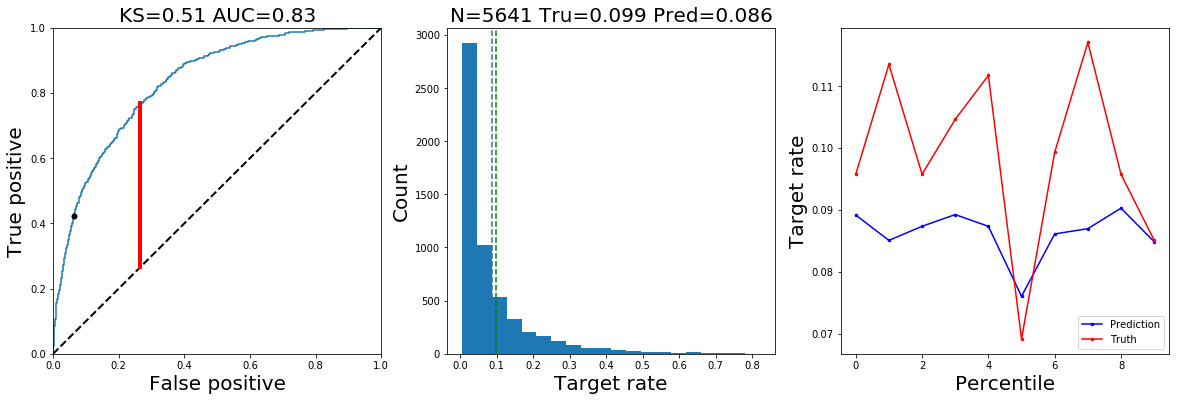

0.50544532288434019

In [13]:
mt.evaluate_performance(test_result['target'],test_result['score'])

In [14]:
for i in range(1,n_splits+1):
    imp['imp_fold%d'%i] = imp['imp_fold%d'%i]/imp['imp_fold%d'%i].sum()
imp['sum_imp'] = imp[['imp_fold%d'%i for i in range(1,n_splits+1)]].sum(axis=1)

In [15]:
imp.sort_values('sum_imp',ascending=False)
tmpPredictor = imp.sort_values('sum_imp',ascending=False)['variable'].values.tolist()[0:100]

In [16]:
test_result,result,imp_selected = mm.xgb_kfold(dfTrain,dfPred,tmpPredictor,n_splits,early_stop = early_stop,params=params)

[0]	train-logloss:0.686013	eval-logloss:0.686502
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.329557	eval-logloss:0.368862
[200]	train-logloss:0.222955	eval-logloss:0.292715
[300]	train-logloss:0.177442	eval-logloss:0.271188
[400]	train-logloss:0.150653	eval-logloss:0.265468
[500]	train-logloss:0.130738	eval-logloss:0.264128
Stopping. Best iteration:
[522]	train-logloss:0.126592	eval-logloss:0.263814

Best tree is 523, performance is 0.126592, 0.263814
[0]	train-logloss:0.686002	eval-logloss:0.686391
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.329858	eval-logloss:0.36391
[200]	train-logloss:0.223418	eval-logloss:0.288009
[300]	train-logloss:0.177261	eval-logloss:0.267338
[400]	train-logloss:0.151241	eval-logloss:0.260749
[500]	train-logl

KS=0.518, AUC=0.84, N=5641
At threshold=0.099, TPR=0.43, 238 out of 557
At threshold=0.099, FPR=0.06, 321 out of 5084
Ave_target: [ 0.10460993  0.09751773  0.10638298  0.09042553  0.11170213  0.08333333
  0.09929078  0.11879433  0.09042553  0.08510638]
Ave_predicted: [ 0.09222797  0.08634714  0.08599137  0.09364516  0.08455823  0.0823897
  0.08289535  0.09156416  0.08495802  0.08826611]
plot


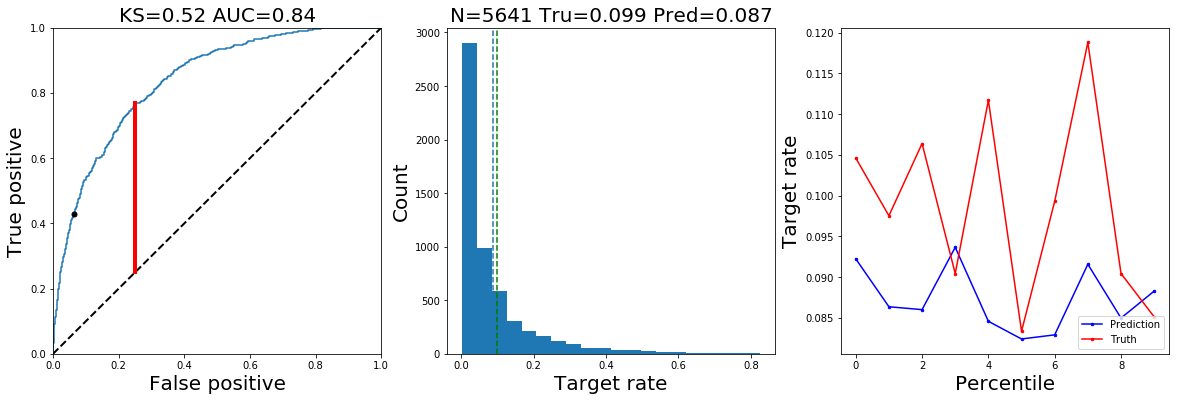

0.51781206785253697

In [17]:
mt.evaluate_performance(test_result['target'],test_result['score'])

In [18]:
imp.sort_values('sum_imp',ascending=False)

,lk,variable,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,sum_imp
37,f37,age,0.043478,0.042784,0.038830,0.040553,0.038249,0.203894
992,f992,pcent_PartV_6_based_PartV_5,0.010009,0.005658,0.013241,0.011109,0.008713,0.048730
1064,f1064,pcent_PartV_8_based_PartV_5,0.009448,0.009998,0.006986,0.008313,0.008565,0.043311
1445,f1445,pcent_age_based_PartII_1,0.007366,0.008138,0.011292,0.007691,0.006572,0.041059
1440,f1440,pcent_age_based_PartI_4,0.007366,0.007828,0.008286,0.007769,0.006424,0.037673
1141,f1141,pcent_PartVI_2_based_PartVI_3,0.006486,0.007208,0.006661,0.005904,0.007310,0.033569
593,f593,pcent_PartIII_3_based_PartV_3,0.006646,0.006821,0.003574,0.006370,0.007605,0.031017
1438,f1438,pcent_age_based_PartI_2,0.005125,0.004883,0.007067,0.007225,0.005538,0.029838
1414,f1414,pcent_sex_PartIII_3,0.006165,0.005581,0.004793,0.004739,0.007605,0.028883
55,f55,PartV_2_multiply_PartV_7,0.003123,0.002868,0.010561,0.004817,0.005538,0.026906


In [ ]:
n_splits=5
other_note ='_sick_test'
result['score']=result[['Score_%d'%i for i in range(1,n_splits+1)]].mean(axis=1)
submit = result[['ID','score']]
today = datetime.date.today().strftime('%Y-%m-%d')
result.to_csv('../../Submission/result/result_%s'%today+other_note+'.csv',index=False)
submit['score'].to_csv('../../Submission/submit_%s'%today+other_note+'.csv',header=False,index=False)
test_result.to_csv('../../Submission/test/test_result_%s'%today+other_note+'.csv',index=False)
imp.to_csv('../../Submission/imp/importance_%s'%today+other_note+'.csv',index=False)

In [ ]:
###基础变量
1.83977998784

###增加部分比例数据，已经缺失体检项目情况
1.84295123211  imp来看，missing信息没有意义

###上一版去除missing
1.83839589522



###增加一些比值信息
1.84354856365


###根据日期的百分比，效果更加不好了
1.85046680299  变量选择之后 1.83862284729


###前面所有的特征
1.86013896413   变量选择之后  1.85446185976